<a href="https://colab.research.google.com/github/KadjelRamkisoen/BertIR/blob/main_kate/chuncks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 78 kB 3.2 MB/s 
     |████████████████████████████████| 3.1 MB 21.9 MB/s 
     |████████████████████████████████| 3.3 MB 20.2 MB/s 
     |████████████████████████████████| 1.2 MB 30.6 MB/s 
     |████████████████████████████████| 61 kB 338 kB/s 
     |████████████████████████████████| 895 kB 20.4 MB/s 
     |████████████████████████████████| 596 kB 27.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=855237f556d3a6d4f2c1409baf91022300af52ab18c2369c08512087b8f08c1d
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install -U rank_bm25

In [12]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Path to data files
# IR_Path = '/content/drive/MyDrive/UvAntwerpen/2021-2022/Information Retrieval/Assignment 2/'
IR_Path = '/content/drive/MyDrive/Information Retrieval/Assignment 2/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
dev_data = 'dev_data.csv'
all_docs = 'all_docs.csv'
dev_queries = 'dev_queries.csv'
test_data = 'test_data.csv'
training_data = 'training_data.csv'
lucene_data = 'raw_dev_Lucene_retrievals.csv'

In [14]:
# from sentence_transformers import SentenceTransformer, CrossEncoder, util
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# df_all_docs = pd.read_csv(IR_Path + all_docs)
# df = pd.read_csv(IR_Path + all_docs)
# df = pd.read_csv(IR_Path + dev_queries)
# df = pd.read_csv(IR_Path + test_data)
df_all_docs = pd.read_csv(IR_Path + training_data)
# df = pd.read_csv(IR_Path + lucene_data)

In [27]:
# Read first 5 lines
df_all_docs.head()

,Query_number,Query,doc_text,doc_number,index,label
0,166043,does estrogen make me start my period,Estrogen patch types Common Questions and Answ...,31135,23076,1
1,284072,how many gallons is liters,Answers.com ® Wiki Answers ® Categories Cars &...,317907,27572,1
2,277737,how many calories in skyy vodka,Vodka Tonic (7)Recipe by newspapergal“I couldn...,188074,79593,1
3,1059801,whos the third president of usa,"From Wikipedia, the free encyclopedia (Redirec...",313468,74658,1
4,237561,how is the element magnesium used,1. Biogenic elements. Qualitative reaction for...,33071,28572,1


In [28]:
# Check the column tyes
df_all_docs["doc_text"] = df_all_docs["doc_text"].astype('str')
print(df_all_docs.dtypes)
df_all_docs['words']=df_all_docs['doc_text'].str.count(' ')+1

Query_number     int64
Query           object
doc_text        object
doc_number       int64
index            int64
label            int64
dtype: object


In [18]:
import re
def clean_txt(text):
  text=re.sub("[^0-9a-zA-Z ]","",text)  
  text=re.sub(" +"," ",text)  
  return text

In [19]:
clean_txt("He llo     world!")

'He llo world'

In [29]:
df_all_docs['doc_text']  = df_all_docs.doc_text.apply(clean_txt)
df_all_docs['new_words']=df_all_docs['doc_text'].str.count(' ')+1

In [30]:
df_all_docs.head()

,Query_number,Query,doc_text,doc_number,index,label,words,new_words
0,166043,does estrogen make me start my period,Estrogen patch types Common Questions and Answ...,31135,23076,1,2309,2308
1,284072,how many gallons is liters,Answerscom Wiki Answers Categories Cars Vehicl...,317907,27572,1,648,639
2,277737,how many calories in skyy vodka,Vodka Tonic 7Recipe by newspapergalI couldnt b...,188074,79593,1,110,109
3,1059801,whos the third president of usa,From Wikipedia the free encyclopedia Redirecte...,313468,74658,1,6030,5970
4,237561,how is the element magnesium used,1 Biogenic elements Qualitative reaction for i...,33071,28572,1,14987,14735


In [31]:
df_all_docs.describe()

,Query_number,doc_number,index,label,words,new_words
count,1.400000e+05,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000
mean,6.864098e+05,250200.066007,80928.179693,0.497214,1813.086979,1789.593914
std,3.429180e+05,144445.551553,46554.882928,0.499994,3335.987168,3297.018457
min,2.000000e+00,8.000000,0.000000,0.000000,1.000000,1.000000
25%,4.150735e+05,125955.000000,40293.750000,0.000000,553.000000,546.000000
50%,7.545090e+05,249573.000000,81007.500000,0.000000,955.000000,944.000000
75%,1.009109e+06,375196.500000,121147.250000,1.000000,1904.000000,1879.000000
max,1.089051e+06,501673.000000,161812.000000,1.000000,165192.000000,164067.000000


In [32]:
df_all_docs.dropna(inplace=True)
df_all_docs.drop_duplicates(subset=['doc_text', 'Query'],inplace=True)

In [33]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())// 511>0:
    n = len(text1.split())//511
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:511]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*461:w*461 + 511]
      l_total.append(" ".join(l_parcial))
  return l_total

In [34]:
df_all_docs['text_split'] = df_all_docs['doc_text'].apply(get_split)
df_all_docs.head()

,Query_number,Query,doc_text,doc_number,index,label,words,new_words,text_split
0,166043,does estrogen make me start my period,Estrogen patch types Common Questions and Answ...,31135,23076,1,2309,2308,[Estrogen patch types Common Questions and Ans...
1,284072,how many gallons is liters,Answerscom Wiki Answers Categories Cars Vehicl...,317907,27572,1,648,639,[Answerscom Wiki Answers Categories Cars Vehic...
2,277737,how many calories in skyy vodka,Vodka Tonic 7Recipe by newspapergalI couldnt b...,188074,79593,1,110,109,[Vodka Tonic 7Recipe by newspapergalI couldnt ...
3,1059801,whos the third president of usa,From Wikipedia the free encyclopedia Redirecte...,313468,74658,1,6030,5970,[From Wikipedia the free encyclopedia Redirect...
4,237561,how is the element magnesium used,1 Biogenic elements Qualitative reaction for i...,33071,28572,1,14987,14735,[1 Biogenic elements Qualitative reaction for ...


In [40]:
docs_l = []
label_l = []
index_l =[]
query_l = []
for idx,row in df_all_docs.iterrows():
  for l in row['text_split']:
    docs_l.append(l)
    label_l.append(row['label'])
    query_l.append(row['Query'])
    index_l.append(idx)
len(docs_l), len(label_l), len(index_l)

(446387, 446387, 446387)

In [38]:
df_all_docs.shape

(138784, 9)

In [39]:
446387/138784

3.2164154369379756

In [42]:
df_full = pd.DataFrame({"doc_text":docs_l, 'label':label_l, 'query': query_l})
df_full.head(30)

,doc_text,label,query
0,Estrogen patch types Common Questions and Answ...,1,does estrogen make me start my period
1,reason Estrogen gives me migraines and with th...,1,does estrogen make me start my period
2,husband and small children dont deserve it I w...,1,does estrogen make me start my period
3,dont work What if I take a medication that mes...,1,does estrogen make me start my period
4,Answerscom Wiki Answers Categories Cars Vehicl...,1,how many gallons is liters
5,Vodka Tonic 7Recipe by newspapergalI couldnt b...,1,how many calories in skyy vodka
6,From Wikipedia the free encyclopedia Redirecte...,1,whos the third president of usa
7,1789 when the Constitution went into effect ma...,1,whos the third president of usa
8,consisting of 5 delegates and one resident com...,1,whos the third president of usa
9,each house may name special or select committe...,1,whos the third president of usa


In [47]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_full[:10000], test_size=0.2, random_state=35, shuffle=True)

In [48]:
df_train.shape

(8000, 3)

In [51]:
#Installing BERT module
!pip install bert-tensorflow

     |████████████████████████████████| 64 kB 1.9 MB/s 


In [54]:
#Importing BERT modules
import bert
import tensorflow as tf
import tensorflow_hub as hub
from bert import run_classifier
from bert import optimization
from bert import tokenization

ModuleNotFoundError: ignored

In [57]:
!pip install sentence-transformers 

     |████████████████████████████████| 78 kB 3.3 MB/s 
     |████████████████████████████████| 1.2 MB 11.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=cd72d61ea804032f51a38105e86859e7908d5d09539bdfca07bc5e6a46d86a8d
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers


In [58]:
from sentence_transformers import InputExample

In [76]:
train_InputExamples = df_train.apply(lambda x: InputExample(guid=None,
                                                                   
                                                                   text_a =x['query'], 
                                                          text_b = x['doc_text'],
                                                                   label = x['label']), axis = 1)

test_InputExamples = df_test.apply(lambda x: InputExample(guid=None, 
                                                                   text_a =x['query'], 
                                                          text_b = x['doc_text'],
                                                                   label = x['label']), axis = 1)

In [60]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/ms-marco-TinyBERT-L-6')
tokenizer = AutoTokenizer.from_pretrained('cross-encoder/ms-marco-TinyBERT-L-6')


Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/541 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [77]:
label_list = [0,1]
MAX_SEQ_LENGTH = 512

In [71]:
import tqdm

In [75]:
class PaddingInputExample(object):
  pass
    
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [78]:
# Convert our train and validation features to InputFeatures that BERT understands.
train_features = convert_examples_to_features(tokenizer, train_InputExamples, MAX_SEQ_LENGTH )

test_features = convert_examples_to_features(tokenizer, test_InputExamples, MAX_SEQ_LENGTH)

Converting examples to features: 100%|██████████| 2000/2000 [00:00<00:00, 2829.71it/s]


In [67]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

In [88]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Sentence : ", train_InputExamples.iloc[0].text_b)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_b))


Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


Sentence :  what is upsell
------------------------------
Tokens :  ['what', 'is', 'ups', '##ell']
------------------------------
Sentence :  The Secret to Successful Customer Onboarding Tweet Another awesome article by Lincoln Murphy 50 Comments Tambm disponvel em Portugus por Mathias Luz Customer onboarding has come up a lot lately which is great since having a poor onboarding experience for your customers can pretty much kill your growth if not your business The first inapp experience your customer has with your product sets the tone for your relationship and if its confusing overwhelming or otherwise puts up barriers to achieving success or at least recognizing the value potential in your product youre in trouble As I say all the time the seeds of churn are planted early and those seeds are planted deep if your onboarding experience for new customers or your prospects during a free trial is terrible Every time I talk to a lowtouch selfservice Saa S company experiencing massive drop

In [100]:
class BertLayer(tf.keras.layers.Layer):
    
    def __init__(self, bert_path, n_fine_tune_encoders=10, **kwargs,):
        
        self.n_fine_tune_encoders = n_fine_tune_encoders
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        super(BertLayer, self).__init__(**kwargs)

        
    def build(self, input_shape):
        self.bert = tf_hub.load(self.bert_path)

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [var for var in trainable_vars 
                                  if not "/cls/" in var.name]
        trainable_layers = ["embeddings", "pooler/dense"]


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_encoders+1):
            trainable_layers.append(f"encoder/layer_{str(10 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [var for var in trainable_vars
                                  if any([l in var.name 
                                              for l in trainable_layers])]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:# and 'encoder/layer' not in var.name:
                self._non_trainable_weights.append(var)
        print('Trainable layers:', len(self._trainable_weights))
        print('Non Trainable layers:', len(self._non_trainable_weights))

        super(BertLayer, self).build(input_shape)

        
    def call(self, inputs):
        
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, 
                           input_mask=input_mask, 
                           segment_ids=segment_ids)
        
        pooled = self.bert(inputs=bert_inputs, 
                           signature="tokens", 
                           as_dict=True)["pooled_output"]

        return pooled

    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size) 

In [98]:
# Build model
def build_model(bert_path, max_seq_length, n_fine_tune_encoders=10): 
    
    inp_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    inp_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    inp_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [inp_id, inp_mask, inp_segment]
    
    bert_output = BertLayer(bert_path=bert_path, 
                            n_fine_tune_encoders=n_fine_tune_encoders)(bert_inputs)
    
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
                  metrics=['accuracy'])    
    return model

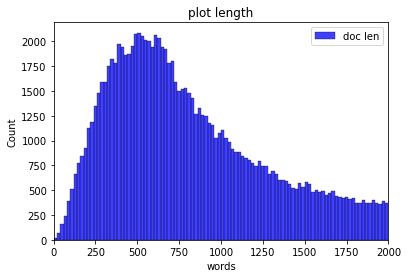

In [26]:
# df_all_docs['doc_len'] = df_all_docs['words'].apply(lambda words: len(words))
sns.histplot(df_all_docs['words'], bins=100, kde=False, color='b', label='doc len', binrange= [0,2000])
plt.title('plot length'); 
plt.legend()
plt.xlim([0, 2000])
plt.show()

In [91]:
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
    

In [95]:
import tensorflow_hub as tf_hub

In [93]:
MAX_SEQ_LENGTH

BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [101]:
model = build_model(bert_path=BERT_PATH, max_seq_length=MAX_SEQ_LENGTH, n_fine_tune_encoders=10)

# Instantiate variables
initialize_vars(sess)

ValueError: ignored

In [102]:
class BertLayer(tf.keras.layers.Layer):
    
    def __init__(self, bert_path, n_fine_tune_encoders=10, **kwargs,):
        
        self.n_fine_tune_encoders = n_fine_tune_encoders
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        super(BertLayer, self).__init__(**kwargs)

        
    def build(self, input_shape):
        self.bert = tf_hub.Module(self.bert_path,
                                  trainable=self.trainable, 
                                  name=f"{self.name}_module")

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [var for var in trainable_vars 
                                  if not "/cls/" in var.name]
        trainable_layers = ["embeddings", "pooler/dense"]


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_encoders+1):
            trainable_layers.append(f"encoder/layer_{str(10 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [var for var in trainable_vars
                                  if any([l in var.name 
                                              for l in trainable_layers])]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:# and 'encoder/layer' not in var.name:
                self._non_trainable_weights.append(var)
        print('Trainable layers:', len(self._trainable_weights))
        print('Non Trainable layers:', len(self._non_trainable_weights))

        super(BertLayer, self).build(input_shape)

        
    def call(self, inputs):
        
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, 
                           input_mask=input_mask, 
                           segment_ids=segment_ids)
        
        pooled = self.bert(inputs=bert_inputs, 
                           signature="tokens", 
                           as_dict=True)["pooled_output"]

        return pooled

    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size) 

In [103]:
# Build model
def build_model(bert_path, max_seq_length, n_fine_tune_encoders=10): 
    
    inp_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    inp_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    inp_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [inp_id, inp_mask, inp_segment]
    
    bert_output = BertLayer(bert_path=bert_path, 
                            n_fine_tune_encoders=n_fine_tune_encoders)(bert_inputs)
    
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
                  metrics=['accuracy'])    
    return model

In [104]:
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [105]:
model = build_model(bert_path=BERT_PATH, max_seq_length=MAX_SEQ_LENGTH, n_fine_tune_encoders=10)

# Instantiate variables
initialize_vars(sess)

RuntimeError: ignored

In [141]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_PATH,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)
  print(input_ids)
  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [137]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features[0]
    print(input_ids)
    input_mask = features[1]
    segment_ids = features[2]
    label_ids = features[3]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [126]:
len(train_features[0])

8000

In [127]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features[0]) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=IR_Path,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=IR_Path,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [128]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/Information Retrieval/Assignment 2/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/Information Retrieval/Assignment 2/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [120]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
test_input_fn = input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [122]:
from datetime import datetime

In [129]:
num_train_steps

500

In [143]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("IteratorGetNext:0", shape=(None, 512), dtype=int32, device=/device:CPU:0)


AttributeError: ignored

In [ ]:
 BERT_PATH

In [142]:
# This function is not used by this file but is still used by the Colab and
# people who depend on it.
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = features[0]
  all_input_mask = features[1]
  all_segment_ids = features[2]
  all_label_ids = features[3]

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features[0])

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn


In [ ]:
if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")

#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# As dataset, we use Simple English Wikipedia. Compared to the full English wikipedia, it has only
# about 170k articles. We split these articles into paragraphs and encode them with the bi-encoder

passages = []
for index, row in df_all_docs:
  data = row['doc_text']

  #Add all paragraphs
  #passages.extend(data['paragraphs'])

  #Only add the first paragraph
        passages.append(data['paragraphs'][0])

print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

In [ ]:
# We also compare the results to lexical search (keyword search). Here, we use 
# the BM25 algorithm which is implemented in the rank_bm25 package.

from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
from tqdm.autonotebook import tqdm
import numpy as np


# We lower case our text and remove stop-words from indexing
def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc


tokenized_corpus = []
for passage in tqdm(passages):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)


In [ ]:
# This function will search all wikipedia articles for passages that
# answer the query
def search(query):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -5)[-5:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)
    
    print("Top-3 lexical search (BM25) hits")
    for hit in bm25_hits[0:3]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    print("\n-------------------------\n")
    print("Top-3 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:3]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    # Output of top-5 hits from re-ranker
    print("\n-------------------------\n")
    print("Top-3 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:3]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))


In [19]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.7 MB/s 
     |████████████████████████████████| 895 kB 46.0 MB/s 
     |████████████████████████████████| 61 kB 486 kB/s 
     |████████████████████████████████| 3.3 MB 36.0 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [20]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

[{'entity': 'B-PER', 'score': 0.99901396, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


In [22]:
nlp = pipeline("ner", tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

RuntimeError: ignored

In [24]:
tokens = tokenizer.tokenize("My name is Wolfgang and I live in Berlin")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['My', 'name', 'is', 'Wolfgang', 'and', 'I', 'live', 'in', 'Berlin']
[1422, 1271, 1110, 14326, 1105, 146, 1686, 1107, 3206]
